In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from datetime import date, datetime
from scipy.optimize import curve_fit

# Analysis of Bitcoin dust

Read the TX input and output data from the corresponding compressed files.

In [2]:
inputs = pd.read_csv('dust/inputs_1-545.csv.xz', compression='xz')
outputs = pd.read_csv('dust/outputs_1-545.csv.xz', compression='xz')

Preview the corresponding data sets and print some basic information.

In [3]:
inputs.head()

,timestamp,blockId,txId,address,amount,prevTxId,prevTxOffset
0,1286043759,83226,124052,118890,99,121412,1
1,1286048669,83232,124069,118890,99,121404,0
2,1292087817,97050,205875,157345,44,202325,0
3,1304444879,121655,466304,393175,100,465857,1
4,1304927240,122844,484748,439046,2,453984,0


In [4]:
outputs.head()

,timestamp,blockId,txId,address,amount,scriptType,offset
0,1285666089,82560,121385,118890,99,2,0
1,1285666089,82560,121386,118890,99,2,0
2,1285666864,82561,121403,118890,99,2,0
3,1285666864,82561,121404,118890,99,2,0
4,1285666864,82561,121405,118890,99,2,0


In [5]:
print('N. of inputs:\t{}\nN. of outputs:\t{}'.format(len(inputs), len(outputs)))

N. of inputs:	2569846
N. of outputs:	4400757


## Global analysis

Let's start by counting how many different transactions are creating dust (i.e., with at least 1 dust output)
and how many of them are consuming dust (i.e., they have at least one dust input).

In [6]:
print('N. of transactions creating dust:\t{}\nN. of transactions consuming dust:\t{}'.format(
    outputs['txId'].nunique(), inputs['txId'].nunique()))

N. of transactions creating dust:	1705560
N. of transactions consuming dust:	429544


Then, we create four different plots.

1. The first plot counts the number of dust-creating transactions with exactly $x$ dust outputs.
2. The second plot counts the number of dust-consuming transactions with exactly $x$ dust inputs.
3. The third plot shows the composition of outputs of dust-creating transactions. 
4. The fourth plot shows the composition of inputs for dust-consuming transactions.

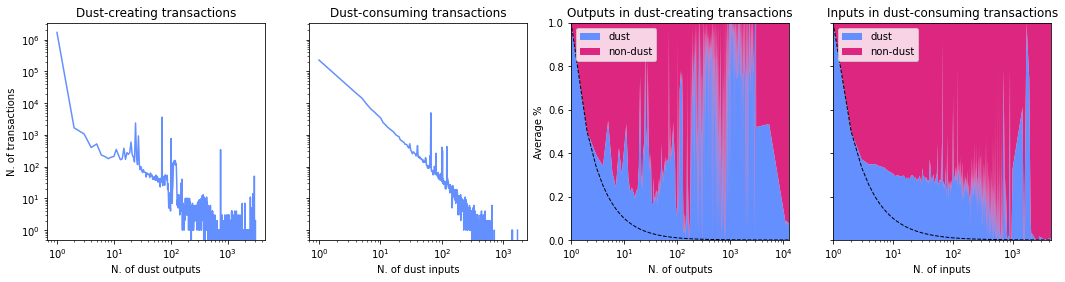

In [7]:
z_out = pd.DataFrame(outputs.groupby('txId').size())[0].value_counts().sort_index()
z_in = pd.DataFrame(inputs.groupby('txId').size())[0].value_counts().sort_index()
data1 = z_out.reindex([i for i in range(1,z_out.index.max()+1)], fill_value=0)
data2 = z_in.reindex([i for i in range(1,z_in.index.max()+1)], fill_value=0)

#def power_law(x, a, b):
#    return a*np.power(x, b)
#
#pars, cov = curve_fit(f=power_law, xdata=np.array(data2.index), 
#                      ydata=np.array(data2), p0=[0, 0], bounds=(-np.inf, np.inf))

fig = plt.figure(figsize=(18,4))

ax1 = fig.add_subplot(1, 4, 1)
ax1.set_title('Dust-creating transactions')
ax1.set_xlabel('N. of dust outputs')
ax1.set_ylabel('N. of transactions')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(list(data1.index), data1, color='#648fff')

ax2 = fig.add_subplot(1, 4, 2, sharey=ax1)

ax2.set_title('Dust-consuming transactions')
ax2.set_xlabel('N. of dust inputs')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(list(data2.index), data2, color='#648fff')
#ax2.plot(np.array(data2.index), power_law(np.array(data2.index), *pars), 
#         linestyle='--', linewidth=1, color='black')

ax3 = fig.add_subplot(1, 4, 3)
df = pd.read_csv('dust/output_composition.csv')
sd = df.groupby('outputCount').mean()['dustCount']
sn = (sd.index.to_series())-sd
data = pd.DataFrame({'dust':sd,'nondust':sn})
data_perc = data.divide(data.sum(axis=1), axis=0)
ax3.set_title('Outputs in dust-creating transactions')
ax3.set_xlabel('N. of outputs')
ax3.set_ylabel('Average %')
ax3.margins(0,0)
ax3.set_xscale('log')
ax3.plot(np.array(sd.index), 1/np.array(sd.index), linestyle='--', linewidth=1, color='black')
ax3.stackplot(list(sd.index),data_perc['dust'],data_perc['nondust'],colors=['#648fff','#dc267f'],labels=['dust', 'non-dust'])
ax3.legend(loc='upper left')

ax4 = fig.add_subplot(1, 4, 4, sharey=ax3)
df = pd.read_csv('dust/input_composition.csv')
sd = df.groupby('inputCount').mean()['dustCount']
sn = (sd.index.to_series())-sd
data = pd.DataFrame({'dust':sd,'nondust':sn})
data_perc = data.divide(data.sum(axis=1), axis=0)
ax4.set_title('Inputs in dust-consuming transactions')
ax4.set_xlabel('N. of inputs')
ax4.margins(0,0)
ax4.set_xscale('log')
ax4.plot(np.array(sd.index), 1/np.array(sd.index), linestyle='--', linewidth=1, color='black')
ax4.stackplot(list(sd.index),data_perc['dust'],data_perc['nondust'],colors=['#648fff','#dc267f'],labels=['dust', 'non-dust'])
ax4.legend(loc='upper left')

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.savefig("dust/global.pdf", format='pdf', bbox_inches='tight')
plt.show()

##  Address analysis

In this section we perform an analysis of the addresses involved in transactions that create and/or spend dust.

### Top receivers

We examine the top dust receivers (_consumers_). For each address, we count how many transactions with at least 1 dust input include that address among their inputs.

* 7470171 =>  1PEDJAibfNetJzM289oXsW1qLAgjYDjLgN (Satoshi Dice: https://bitcointalk.org/index.php?topic=127531.msg1354585#msg1354585)
* 5483937 =>  15tcsumFPsrw2p9Egmk7wGszFJVxpw7UiD (Satoshi Dice: https://bitcointalk.org/index.php?topic=80312.160)
* 2931635 =>  18d3HV2bm94UyY4a9DrPfoZ17sXuiDQq2B (Eligius: https://bitcointalk.org/index.php?topic=441465.2180)
* 8080430 =>  14z1fVwxMG71WcijX9J9te8G1wyp7tVqdz (Satoshi Dice: https://bitcointalk.org/index.php?topic=80312.540;wap2)
* 4437657 =>  1FE1CDgkqzMSFXFreXrET7hvhEfCP9QabY (Satoshi Dice)

In [11]:
outputs.groupby('address').agg({'txId' : 'nunique'})['txId'].nlargest(n=5, keep='first')

address
7470171    14337
5483937    11131
2931635     8099
8080430     7628
4437657     3739
Name: txId, dtype: int64

### Top senders

We now examine the top dust senders (_creators_), namely those addresses involved in transactions that contain dust in their outputs. As for receivers, we take the top 5 addresses and associate them with their real identities. Curiously enough, they are all related to Satoshi Dice.

* 3524394 => 1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp
* 3517636 => 1dice97ECuByXAvqXpaYzSaQuPVvrtmz6
* 3525822 => 1dice6YgEVBf88erBFra9BHf6ZMoyvG88
* 3534212 => 1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx
* 3525858 => 1dice1e6pdhLzzWQq7yMidf6j8eAg7pkY

NOTICE: in this case, for each address we are counting how many transactions with at least 1 dust output contain that address in their inputs.

In [15]:
df = pd.read_csv('dust/dust_creators.csv')
# We remove duplicate rows (because the same address can appear more than once as a TX input)
df = df.drop_duplicates()
df['dustCreator'].value_counts().nlargest(n=5, keep='first')

3524394    374464
3517636    177201
3525822    127790
3534212    123005
3525858     93724
Name: dustCreator, dtype: int64

## Output analysis

The first step is to determine whether a TX output has been spent or not.
If the output has been spent, then we are interested in finding the id of the spending TX and the corresponding timestamp.

To these aims, we start by rearranging and renaming the colums of the `inputs` dataframe.

In [16]:
inputs_mod = inputs[['txId', 'blockId', 'timestamp', 'prevTxId', 'address', 'amount', 'prevTxOffset']]
inputs_mod = inputs_mod.rename(columns = {'txId':'spentId', 'blockId':'spentBlock', 'timestamp':'spentTimestamp', 'prevTxId':'txId', 'prevTxOffset':'offset'})
inputs_mod.head()

,spentId,spentBlock,spentTimestamp,txId,address,amount,offset
0,124052,83226,1286043759,121412,118890,99,1
1,124069,83232,1286048669,121404,118890,99,0
2,205875,97050,1292087817,202325,157345,44,0
3,466304,121655,1304444879,465857,393175,100,1
4,484748,122844,1304927240,453984,439046,2,0


Now we perform a join between the modified inputs dataframe and the outputs table to classify all outputs and see whether they have been spent or they are still unspent.

In the resulting table, the `spentId` column will contain the identifier of the transaction where the output has been spent, or -1 if the output is unspent. The same applies to the TX timestamp.

In [17]:
result = pd.merge(outputs, inputs_mod, on=['txId', 'address', 'amount', 'offset'], how='left', indicator=False)
result['spentId']=result['spentId'].fillna(-1).astype(int)
result['spentBlock']=result['spentBlock'].fillna(-1).astype(int)
result['spentTimestamp']=result['spentTimestamp'].fillna(-1).astype(int)
result.head()

,timestamp,blockId,txId,address,amount,scriptType,offset,spentId,spentBlock,spentTimestamp
0,1285666089,82560,121385,118890,99,2,0,-1,-1,-1
1,1285666089,82560,121386,118890,99,2,0,-1,-1,-1
2,1285666864,82561,121403,118890,99,2,0,-1,-1,-1
3,1285666864,82561,121404,118890,99,2,0,124069,83232,1286048669
4,1285666864,82561,121405,118890,99,2,0,-1,-1,-1


### Spent outputs

Now we focus on all spent outputs (i.e., those whose `spentId` is different from -1).

We would like to classify them according to the kind of transaction they belong to.

 * Type 0: transactions without any input.
 * Type 1: transactions that do not aggregate any dust output.
 * Type 2: transactions that combine dust with larger amounts.
 * Type 3: transactions that only aggregate dust outputs.
 * Type 4: unrecognized type.

In [21]:
spent = result[result.spentId != -1]
spent.head()

,timestamp,blockId,txId,address,amount,scriptType,offset,spentId,spentBlock,spentTimestamp
3,1285666864,82561,121404,118890,99,2,0,124069,83232,1286048669
11,1285666864,82561,121412,118890,99,2,1,124052,83226,1286043759
14,1291439070,95420,202325,157345,44,1,0,205875,97050,1292087817
25,1303898162,120476,444017,426688,1,2,1,553669,126415,1306269462
26,1304142356,120986,453984,439046,2,2,0,484748,122844,1304927240


At this point, the number of spent outputs should be equal to the number of inputs.

In [22]:
print('Number of spent outputs: {}\nNumber of inputs: {}'.format(len(spent), len(inputs)))

Number of spent outputs: 2569846
Number of inputs: 2569846


To classify all spent outputs, we import the TX classification data set. Here, each transaction identifier is associated with a code that describes whether it fully aggregates dust or not.

We perform a join between the spent outputs table and the classified TX data to classify all spent outputs.

### Unspent outputs

Let's focus on the unspent TX outputs and compare them against the spent ones.

An output is unspent if and only if its `spentId` is equal to -1.

In [58]:
unspent = result[result.spentId == -1]
unspent.to_csv('dust/unspent_1-545.csv', index=False)
unspent.head()

,timestamp,blockId,txId,address,amount,scriptType,offset,spentId,spentBlock,spentTimestamp
0,1285666089,82560,121385,118890,99,2,0,-1,-1,-1
1,1285666089,82560,121386,118890,99,2,0,-1,-1,-1
2,1285666864,82561,121403,118890,99,2,0,-1,-1,-1
4,1285666864,82561,121405,118890,99,2,0,-1,-1,-1
5,1285666864,82561,121406,118890,99,2,0,-1,-1,-1


### Classification

In this subsection, we classify **ALL** outputs in three categories: 

1. Unspent
2. NOD: spent dust that has been combined with larger (non-dust) amounts.
3. OD: spent dust that has been combined only with other dust.

In [27]:
spentclass = pd.read_csv('dust/spent_1-545.csv.xz', compression='xz')
s1 = pd.Series([len(pd.read_csv('dust/unspent_1-545.csv.xz', compression='xz'))])
s2 = spentclass['type'].value_counts()
s = pd.concat([s1, s2])
s.index = ['Unspent', 'NOD', 'OD']
p = s*100/sum(s)
frame = { 'N. of outputs': s, 'Percentage' : p}
df = pd.DataFrame(frame)
df

,N. of outputs,Percentage
Unspent,1830911,41.604456
NOD,2420707,55.006605
OD,149139,3.388940


### Temporal analysis

In this section we try to discover patterns behind NOD (a.k.a. Type 2) and OD (a.k.a. Type 3) aggregations.
We do so by performing a temporal analysis on the TX output timestamps.

First, we transform the `timestamp` and `spentTimestamp` columns in a human-readable format.

In [28]:
spentclass = pd.read_csv('dust/spent_1-545.csv.xz', compression='xz')

type2 = (spentclass[spentclass.type == 2]).copy()
type2['timestamp'] = type2['timestamp'].apply(lambda t : datetime.fromtimestamp(t))
type2['spentTimestamp'] = type2['spentTimestamp'].apply(lambda t : datetime.fromtimestamp(t))

type3 = (spentclass[spentclass.type == 3]).copy()
type3['timestamp'] = type3['timestamp'].apply(lambda t : datetime.fromtimestamp(t))
type3['spentTimestamp'] = type3['spentTimestamp'].apply(lambda t : datetime.fromtimestamp(t))

Then we examine the number of NOD and OD outputs for each year.

In [29]:
type2_year = type2.groupby(type2.spentTimestamp.dt.year).size()
type2_year = type2_year.rename_axis('Year')
type2_year = type2_year.reindex([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], fill_value=0)

type3_year = type3.groupby(type3.spentTimestamp.dt.year).size()
type3_year = type3_year.rename_axis('Year')
type3_year = type3_year.reindex([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], fill_value=0)

pd.DataFrame({'NOD': type2_year, 'OD': type3_year})

,NOD,OD
Year,,
2009,0,0
2010,3,0
2011,825,0
2012,784148,130
2013,881039,148067
2014,307546,626
2015,395115,1
2016,29171,0
2017,22860,315


We then create two plots: the first shows the NOD and OD consumption over the years [2009,2013], while the second illustrates the OD consumption during 2013.

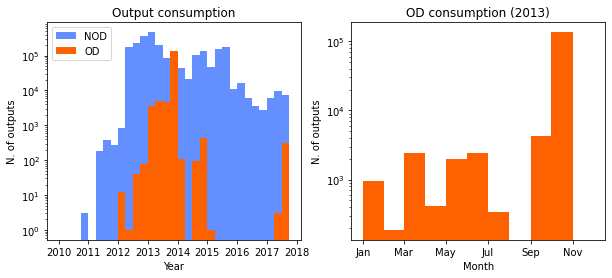

In [11]:
import datetime

type2_data = mdates.date2num(type2['spentTimestamp'].values)
type3_data = mdates.date2num(type3['spentTimestamp'].values)
type3_2013 = (type3[(type3.spentTimestamp.dt.year == 2013)])['spentTimestamp'].values
type3_oct2013 = (type3[(type3.spentTimestamp.dt.year == 2013) & (type3.spentTimestamp.dt.month == 10)])['spentTimestamp'].values

years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
months = [i for i in range(1, 12+1, 3)]
bins = []
for y in years:
    for m in months:
        bins.append(datetime.date(y, m, 1))
hist_bins = mdates.date2num(bins)

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Output consumption')
ax1.set_xlabel('Year')
ax1.set_ylabel('N. of outputs')
ax1.set_yscale('log')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.hist(type2_data, bins=hist_bins, color='#648fff', label='NOD')
ax1.hist(type3_data, bins=hist_bins, color='#fe6100', label='OD')
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(1, 2, 2)
hbins = mdates.date2num([datetime.date(2013, i, 1) for i in range(1, 12+1)])
ax2.set_title('OD consumption (2013)')
ax2.set_xlabel('Month')
ax2.set_ylabel('N. of outputs')
ax2.set_yscale('log')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.hist(type3_2013, bins=hbins, color='#fe6100', label='OD')

#ax3 = fig.add_subplot(1, 3, 3)
#hbins = mdates.date2num([datetime.date(2013, 10, i) for i in range(1, 30+1)])
#ax3.set_title('OD aggregations (Oct 2013)')
#ax3.set_xlabel('Day')
#ax3.set_ylabel('N. of outputs')
#ax3.set_yscale('log')
#ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
#ax3.hist(type3_oct2013, bins=hbins, color='#fe6100', label='OD')

plt.savefig("dust/temporal.pdf", format='pdf', bbox_inches='tight')

#### NOD analysis

For a more in-depth analysis of NOD, we take the top 5 addresses among these outputs.

We discover that the top 3 (highlighted in red) have already been linked to Satoshi Dice.

* <p style="color:red;">7470171 =>  1PEDJAibfNetJzM289oXsW1qLAgjYDjLgN</p>
* <p style="color:red;">8080430 =>  14z1fVwxMG71WcijX9J9te8G1wyp7tVqdz</p>
* <p style="color:red;">2931635 =>  18d3HV2bm94UyY4a9DrPfoZ17sXuiDQq2B</p>
* 8299015 =>  1GmREU2gwcvQHRQFgwHvbD4dyL8iryCPMY
* 10241823 =>  1dES7RLppoYc8mLQedwUoJMZZ9RnuCP5f

In [20]:
type2['address'].value_counts().nlargest(n=5, keep='first')

7470171     12502
8080430      7628
2931635      7288
8299015      3614
10241823     3526
Name: address, dtype: int64

For the remaining two address, namely 8299015 and 10241823, we computed the set of outputs sent by (at least one) known Satoshi Dice address. The goal is to link their activity with this gambling game, as previously done for the first three addresses.

In [22]:
l1 = len(pd.read_csv('dust/satoshi-dice/8299015_outputs_from_sd.csv'))
l2 = len(pd.read_csv('dust/satoshi-dice/10241823_outputs_from_sd.csv'))
print('Outputs received from SD\nAddress 8299015:\t{}\nAddress 10241823:\t{}'.format(l1, l2))

Outputs received from SD
Address 8299015:	3270
Address 10241823:	3526


#### OD analysis

In this section we try to discover patterns behind OD aggregations by analyzing how they have evolved over time.

In [23]:
type3 = (spentclass[spentclass.type == 3]).copy()
type3['timestamp'] = type3['timestamp'].apply(lambda t : datetime.fromtimestamp(t))
type3['spentTimestamp'] = type3['spentTimestamp'].apply(lambda t : datetime.fromtimestamp(t))
type3.head()

,timestamp,blockId,txId,address,amount,scriptType,offset,spentId,spentBlock,spentTimestamp,type
115,2011-06-11 21:15:28,130108,695960,764625,1,2,1,2239783,162928,2012-01-19 19:21:35,3
449,2011-07-14 17:10:16,136256,1034345,1281180,1,2,1,5591703,192185,2012-08-03 23:22:07,3
1095,2011-12-03 05:05:34,155802,1960987,2616722,1,2,1,2195725,161955,2012-01-13 05:55:05,3
1409,2012-01-14 05:09:59,162088,2202123,2847320,1,1,0,2210938,162284,2012-01-15 11:04:23,3
1410,2012-01-14 06:56:27,162100,2202710,2847876,1,1,0,2210938,162284,2012-01-15 11:04:23,3


Let's count how many OD outputs have been spent for each year.

In [24]:
t1 = type3.groupby(type3.spentTimestamp.dt.year).size()
t1 = t1.rename_axis('Year')
t1 = t1.reindex([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], fill_value=0)
t1

Year
2009         0
2010         0
2011         0
2012       130
2013    148067
2014       626
2015         1
2016         0
2017       315
dtype: int64

Most aggregations were performed during 2013.
Taking this year as a reference, we can now discover how many Type 3 aggregations are performed on a monthly basis.
From the results, we can see that the majority of aggregations happened in October (10).

In [30]:
tmp = type3[type3.spentTimestamp.dt.year == 2013]
tmp.groupby(tmp.spentTimestamp.dt.month).size().rename_axis('Month').reindex([1,2,3,4,5,6,7,8,9,10,11,12], fill_value=0)

Month
1        955
2        187
3       2439
4        415
5       1954
6       2462
7        343
8          0
9       4319
10    134993
11         0
12         0
dtype: int64

We now count the number of outputs aggregated by the various addresses in this period.

We find out that address `3108769` has collected 134693 outputs out of a total of 134993.

In [31]:
tmp = type3[(type3.spentTimestamp.dt.year == 2013) & (type3.spentTimestamp.dt.month == 10)]
tmp['address'].value_counts()

3108769     134693
9691207        200
11145561       100
Name: address, dtype: int64

We discover that this address identifier actually corresponds to `1JwSSubhmg6iPtRjtyqhUYYH7bZg3Lfy1T`, which is even mentioned on Reddit: https://www.reddit.com/r/Bitcoin/comments/399220/1jwssubhmg6iptrjtyqhuyyh7bzg3lfy1t_aka_correct/